In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


2026-02-14 22:24:10.583367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771107850.826899      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771107850.897086      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771107851.474990      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771107851.475031      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771107851.475034      23 computation_placer.cc:177] computation placer alr

In [2]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

pneumonia = 'PNEUMONIA'
normal = 'NORMAL'

num_pneumonia = len(os.listdir(os.path.join(train_dir, pneumonia)))
num_normal = len(os.listdir(os.path.join(train_dir, normal)))

print(num_pneumonia, num_normal)


3875 1341


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [4]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
total = num_normal + num_pneumonia

# Standard formula: total / (2 * count)
# This makes the "Normal" weight higher and "Pneumonia" weight lower
weight_for_0 = total / (2 * num_normal)      # Weight for Normal
weight_for_1 = total / (2 * num_pneumonia)   # Weight for Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for Normal (0): {weight_for_0:.2f}")      # Should be around 1.94
print(f"Weight for Pneumonia (1): {weight_for_1:.2f}")   # Should be around 0.67

Weight for Normal (0): 1.94
Weight for Pneumonia (1): 0.67


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Input


model = Sequential()
model.add(Input(shape=(180, 180, 3))) # The "Entry Point"
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

I0000 00:00:1771107870.717872      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771107870.723823      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1771107876.588524      90 service.cc:152] XLA service 0x7bff38009850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771107876.588560      90 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771107876.588567      90 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771107877.424675      90 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-14 22:24:39.742551: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 22:24:39.890439: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 22:24:40.143985: E external/local_xl

  1/100 ━━━━━━━━━━━━━━━━━━━━ 22:44 14s/step - accuracy: 0.5000 - loss: 1.4616

I0000 00:00:1771107886.502551      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step - accuracy: 0.7192 - loss: 6.0285 - val_accuracy: 0.5000 - val_loss: 24.9538
Epoch 2/10
  3/100 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7500 - loss: 1.9509

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.8100 - loss: 2.8499 - val_accuracy: 0.5000 - val_loss: 23.4091
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.8390 - loss: 0.5416 - val_accuracy: 0.5000 - val_loss: 9.0594
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.8636 - loss: 0.5042 - val_accuracy: 0.5625 - val_loss: 2.2212
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.8860 - loss: 0.2557 - val_accuracy: 0.5625 - val_loss: 3.6627
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.8864 - loss: 0.3545 - val_accuracy: 0.6250 - val_loss: 1.7995
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9424 - loss: 0.1577 - val_accuracy: 0.5625 - val_loss: 3.4898
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9190 - loss: 0.2197 - val_accuracy: 0.5000 - val_loss: 1.1660
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9152 - loss: 0.2391 - val_

Text(0.5, 1.0, 'Accuracy Evolution')

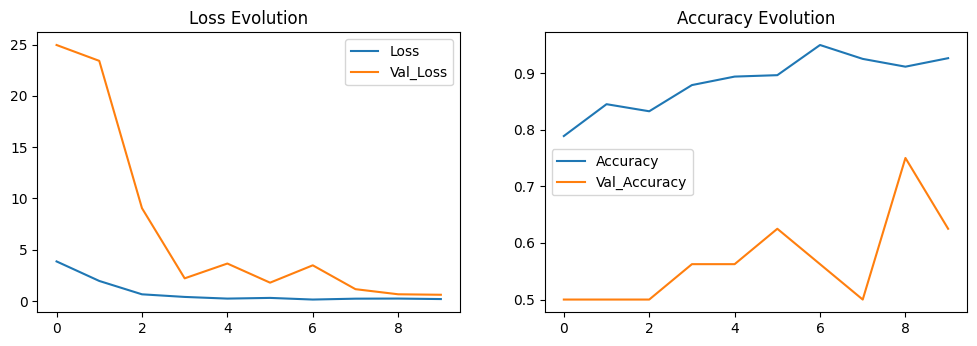

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [9]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8745 - loss: 0.3929
Test Accuracy: 85.58%
652/652 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - accuracy: 0.8819 - loss: 0.3473
Train Accuracy: 88.42%


In [10]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
[[202  32]
 [ 47 343]]


,0,1,accuracy,macro avg,weighted avg
precision,0.811245,0.914667,0.873397,0.862956,0.875884
recall,0.863248,0.879487,0.873397,0.871368,0.873397
f1-score,0.836439,0.896732,0.873397,0.866585,0.874122
support,234.000000,390.000000,0.873397,624.000000,624.000000


In [11]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[205  29]
 [ 68 322]]


,0,1,accuracy,macro avg,weighted avg
precision,0.750916,0.917379,0.844551,0.834147,0.854955
recall,0.876068,0.825641,0.844551,0.850855,0.844551
f1-score,0.808679,0.869096,0.844551,0.838887,0.846439
support,234.000000,390.000000,0.844551,624.000000,624.000000


# Transfer Learning
# DenseNet
Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

* The first layer is connected to the 2nd, 3rd, 4th etc.
* The second layer is conected to the 3rd, 4th, 5th etc.

In [12]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 186, 186,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 90, 90,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 90, 90,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 90, 90,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 92, 92,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 45, 45,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 45, 45,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 45, 45,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 45, 45,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 45, 45,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 45, 45,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 45, 45,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 45, 45,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 45, 45,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 45, 45,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 45, 45,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [13]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [14]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape <KerasTensor shape=(None, 180, 180, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_191>
The output shape <KerasTensor shape=(None, 1024), dtype=float32, sparse=False, ragged=False, name=keras_tensor_618>


In [15]:

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [16]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 240ms/step - accuracy: 0.7562 - loss: 0.6119 - val_accuracy: 0.5625 - val_loss: 1.2683
Epoch 2/10
  2/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 1.0000 - loss: 0.0747

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8994 - loss: 0.2678 - val_accuracy: 0.5625 - val_loss: 1.0688
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8827 - loss: 0.2554 - val_accuracy: 0.5000 - val_loss: 2.1961
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8772 - loss: 0.2835 - val_accuracy: 0.5000 - val_loss: 3.9652
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8944 - loss: 0.2340 - val_accuracy: 0.5000 - val_loss: 1.6014
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8706 - loss: 0.3285 - val_accuracy: 0.6875 - val_loss: 0.7515
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9314 - loss: 0.1815 - val_accuracy: 0.6250 - val_loss: 1.3878
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9365 - loss: 0.1638 - val_accuracy: 0.8750 - val_loss: 0.4933
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9220 - loss: 0.2092 - val_a

Text(0.5, 1.0, 'Accuracy Evolution')

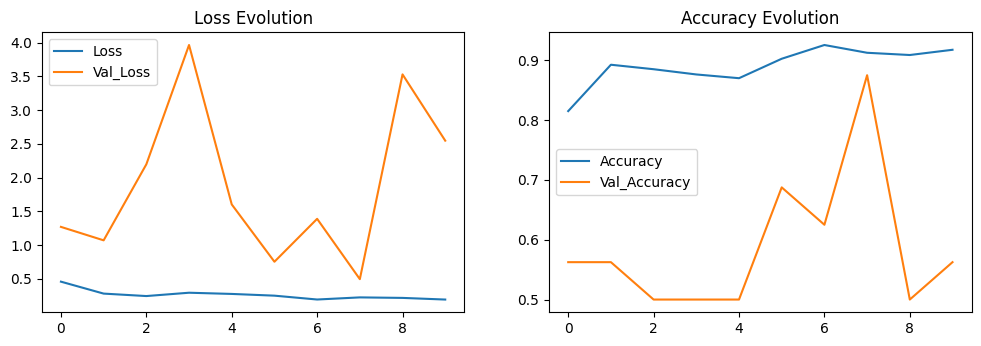

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [18]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4019 - loss: 2.7343
Test Accuracy: 69.55%
652/652 ━━━━━━━━━━━━━━━━━━━━ 86s 119ms/step - accuracy: 0.8970 - loss: 0.3602
Train Accuracy: 89.61%


In [19]:
predicted_vals = model.predict(test, steps=len(test))

624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step


In [20]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[ 58 176]
 [  2 388]]


,0,1,accuracy,macro avg,weighted avg
precision,0.966667,0.687943,0.714744,0.827305,0.792465
recall,0.247863,0.994872,0.714744,0.621368,0.714744
f1-score,0.394558,0.813417,0.714744,0.603988,0.656345
support,234.000000,390.000000,0.714744,624.000000,624.000000
